In [13]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from collections import defaultdict
import datetime
import time
import os
import pickle

class Logger(object):
    
    y_min = -1600
    y_max = 0
    highlight = False
    
    def __init__(self,var_list, log_dir = './', record_time_stamp = True):
        self.logs = defaultdict(list)
        
        self.var_list = var_list
        for var in var_list:
            self.logs[var] = []
        self.record_time_stamp = record_time_stamp

        # Record time stamp
        if self.record_time_stamp:
            self.start_time = datetime.datetime.utcnow()
            self.logs['time'] = []
        
        self.logs['length'] = 0
        self.log_dir = log_dir
        
        if not os.path.exists(self.log_dir):
            os.makedirs(self.log_dir)
        
        self.log_file_path = os.path.join(self.log_dir, 'logs_' + time.strftime("%Y%m%d-%H%M%S") + '.pkl' )
        

    def initialize_time_stamp(self):
        self.start_time = datetime.datetime.utcnow()
    
    def log(self, var_status_list):
        
        for var, var_status in zip(self.var_list, var_status_list):
            self.logs[var].append(var_status)
        
        if self.record_time_stamp:
            self.logs['time'].append((datetime.datetime.utcnow()-self.start_time).total_seconds()/60)
        
        self.logs['length'] += 1
        with open(self.log_file_path, 'wb') as fHandle:
            pickle.dump(self.logs, fHandle, protocol=pickle.HIGHEST_PROTOCOL)

    
    
    @staticmethod
    def createTiles(x=1,y=2,hwidth=8,vwidth=4): 
        fig,plots = plt.subplots(x,y,figsize=(hwidth,vwidth));
        plots = plots.flatten()
        return(fig, plots)
    
    @staticmethod
    def configure_plot_parameters(y_min = -1000, y_max=1000, highlight = False):
        Logger.y_min = y_min
        Logger.y_max = y_max
        Logger.highlight = highlight
    
    @staticmethod
    def highlight_coord(x, y, curr_plot, precision = 2):
        x = x if isinstance(x, list) else [x]
        y = y if isinstance(y, list) else [y]
        for a, b in zip(x, y):
            curr_plot.text(a, b, str(round(b, 2)))
    
    @staticmethod
    def numpy_ewma_vectorized_v2(data, window=20):

        alpha = 2 /(window + 1.0)
        alpha_rev = 1-alpha
        n = data.shape[0]

        pows = alpha_rev**(np.arange(n+1))

        scale_arr = 1/pows[:-1]
        offset = data[0]*pows[1:]
        pw0 = alpha*alpha_rev**(n-1)

        mult = data*pw0*scale_arr
        cumsums = mult.cumsum()
        out = offset + cumsums*scale_arr[::-1]
        return out
    
    @staticmethod
    def plot_logs_from_pickle(train_logs):
        fig, plots = Logger.createTiles(1,2,15,5)
        x_max = sys.maxint
        t_max = 0
        
        avg_rewards = []
        for i, train_log in enumerate(train_logs):
            avg_reward = Logger.numpy_ewma_vectorized_v2(np.array(train_log['total_reward']))
            plots[0].plot(train_log['time'],avg_reward , label = train_log['info_summary'])
#             plots[1].plot(train_log['x_val'], avg_reward, label = train_log['info_summary'])
            plots[1].plot(avg_reward, label = train_log['info_summary'])
            # Save for later highlighting points
            if Logger.highlight:
                avg_rewards.append(avg_reward)
                x_max = min(x_max, len(train_log['time']))

        if Logger.highlight:
            n_points = 6
            delta = x_max//n_points
            curr_x = 0
            for i in range(n_points):
                for j, avg_reward in enumerate(avg_rewards):
                    plots[1].text(curr_x, avg_reward[curr_x], str(round(avg_reward[curr_x], 2)))
                curr_x += delta
            
        print("Max x-steps: ", x_max, "\t max_time: ", t_max)
        plots[0].set_xlabel('time(in minutes)')
        plots[0].set_ylabel('avg_reward')
        plots[0].set_title('Avg reward vs Time')
        plots[0].legend()
        plots[0].set_ylim(Logger.y_min, Logger.y_max)

        plots[1].set_xlabel(train_logs[0]['x'])
        plots[1].set_ylabel('avg_reward')
        plots[1].set_title('Avg reward vs ' + train_logs[0]['x'])
        plots[1].legend()
        plots[1].set_ylim(Logger.y_min, Logger.y_max)
        
        plt.show()         

    @staticmethod
    def plot_logs_from_filepath(*filepaths):
        train_logs = []
        for i, filepath in enumerate(filepaths):
            with open(filepath, 'rb') as fHandle:
                train_log = pickle.load(fHandle)
            train_logs.append(train_log)
        Logger.plot_logs_from_pickle(train_logs)

('Max x-steps: ', 9223372036854775807, '\t max_time: ', 0)


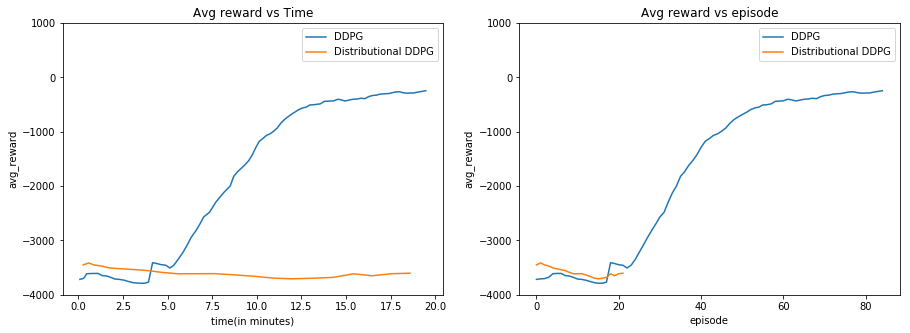

In [22]:
env_name = 'Pendulum-v0'
dist_ddpg_path = '/home/aditya/ADITYA/Project/d4pg-pytorch/train_logs_' + env_name + '_latest_DistDDPG.pkl'
ddpg_path      = '/home/aditya/ADITYA/Project/d3pg-pytorch/train_logs_' + env_name + '_latest_DDPG.pkl'

Logger.configure_plot_parameters(y_min = -4000, y_max = 1000 , highlight = False)
Logger.plot_logs_from_filepath(ddpg_path, dist_ddpg_path)